In [1]:
import sys
sys.path.insert(0, '../classes')

from Model import Model as Model

import pickle


%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from importlib import reload

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
params = {
 'grid.color': '.9',
 'axes.edgecolor': '.5',
 'text.color': '.3',
 'xtick.color': '.5',
 'xtick.direction': 'out',
 'xtick.major.size': 6.0,
 'xtick.minor.size': 3.0,
 'ytick.color': '.5',
 'ytick.direction': 'out',
 'ytick.major.size': 6.0,
 'ytick.minor.size': 3.0    
}
sns.set_style("whitegrid", params)

In [2]:
"""
 CPIAUCSL     : Consumer Price Index for All Urban Consumers: All Items
 FEDFUNDS     : Effective Fed Funds Rate, percent.
 INDPRO       : Industrial Production Index
 UNRATE       : Civilian Unemployment Rate
 PAYEMS       : All Employees: Total Nonfarm Payrolls
"""

data = pd.read_csv('monthly.csv', index_col = 'DATE')
data.head()

,CPIAUCSL,FEDFUNDS,INDPRO,PAYEMS,UNRATE
DATE,,,,,
1959-01-01,29.01,2.48,22.7253,52480.0,6.0
1959-02-01,29.00,2.43,23.1703,52687.0,5.9
1959-03-01,28.97,2.80,23.5041,53016.0,5.6
1959-04-01,28.98,2.96,24.0048,53320.0,5.2
1959-05-01,29.04,2.90,24.3664,53549.0,5.1


In [3]:
import scipy.io as sio

factors_data = sio.loadmat('factors.mat')

# process the factors: raw

factors_q = pd.DataFrame(factors_data['monthly'])

# drop the last period (as done with the data)
factors_q = factors_q[:-1]

# drop every col that has missings after the beginning
factors_q = factors_q.iloc[:, list(factors_q[5:].isnull().sum(axis=0)==0)]


factors_q.head()

,0,1,2,3,4,5,7,8,9,10,...,115,116,117,118,119,121,122,123,127,133
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.2
1,0.019397,0.008625,0.007307,0.031175,0.045030,0.017353,0.005238,-0.040087,0.009512,0.007499,...,0.002912,0.003149,0.003312,0.010540,0.011394,0.010540,-0.015400,-0.002654,0.001995,95.8
2,0.014303,0.004893,0.000000,0.025645,0.038646,0.014914,0.019389,0.061534,-0.004743,0.008682,...,0.001128,0.004179,0.004038,0.008906,0.006671,0.008906,0.024884,0.030673,-0.001424,96.4
3,0.021077,0.014546,0.015651,0.027245,0.029658,0.030500,0.006382,0.002650,0.016509,0.018348,...,-0.002436,0.000671,0.000084,0.006635,0.009462,0.006635,0.016777,0.012837,-0.001998,96.9
4,0.014950,0.009584,0.004768,0.025425,0.034042,0.008942,0.020156,0.018347,0.000000,0.022770,...,0.006001,0.006082,0.006035,0.009587,0.010178,0.009587,0.014949,0.022136,-0.000095,97.5


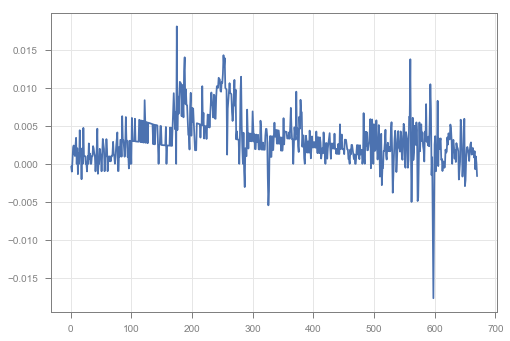

In [4]:
df_raw = data.reset_index(drop = True)
df_raw.columns = ['CPI', 'FF', 'IP', 'emp', 'unemp']

# put the interest variable, CPI, in the format we want to predict: the percentage growth from last period
df = df_raw.copy()
df['CPI'] = df_raw[['CPI']].pct_change()
df = df.iloc[1:]

plt.plot(df['CPI'])

In [5]:
import statsmodels.tsa.stattools as tsa

_, pvalue, *_ = tsa.adfuller(df['CPI'])
print("p-value: " + str(pvalue))

p-value: 0.101430948561


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
def splitTimeData(df, ratio):
    rows = len(df.index)
    trainRows = int(rows * (1 - ratio))
    testRows = rows - trainRows
    
    train = df.iloc[0:trainRows-1]
    test = df
    start = trainRows
    
    return train, test, start

df_train, df_test, start = splitTimeData(df, 0.18)

In [7]:
'''
standard transformations
'''
from Transform import Transform as Transform

cols = ['CPI', 'FF', 'IP', 'emp', 'unemp']

t1 = Transform('log', ['IP', 'emp']) # not FF, nor the unemp

o = {
    'diffs': {
        'unemp': 0,
        'IP': 1,
        'emp': 1,
        'FF': 1
    }
}


t2 = Transform('diff', cols, o)
t3 = Transform('standardize', cols)
# t3 = Transform('normalize', cols)

transfs =  [t1, t2, t3]

In [8]:
'''
standard scorefuns
'''

def RMSE(y_hat, y):
    start = y_hat.first_valid_index()
    errors = y.loc[start:] - y_hat
    RMSE = np.sqrt(np.mean(np.square(errors)))[0]
    return RMSE

def MAE(y_hat, y):
    start = y_hat.first_valid_index()
    errors = y.loc[start:] - y_hat
    MAE = np.mean(np.absolute(errors))[0]
    return MAE

In [12]:
TRAIN_OFFSET = 490

In [13]:
results = {}

# Baseline

In [14]:
from LastPeriod import LastPeriod as LastPeriod

# test
cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 1

def gen_x(X, start):
    X = LastPeriod.gen_X(X, start)
    return X

def gen_y(y, start):
    y = LastPeriod.gen_y(y, start)
    return y

model = LastPeriod()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window =  [1, 4, 12]
ret_base = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'direct')
results['BASE'] = ret_base

[ret_base[h][0] for h in window]

step: 490
step: 500
step: 510
step: 520
step: 530
step: 540
step: 490
step: 500
step: 510
step: 520
step: 530
step: 540
step: 490
step: 500
step: 510
step: 520
step: 530
step: 540


[0.0026426669299049847, 0.0027089186141118333, 0.0031966363811771654]

# Univariate

## AR

In [22]:
from var_model import VAR as VAR

cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

def tune(p):
    lags = p

    def gen_x(X, start):
        X = VAR.gen_X(X, lags, start)
    #     X = X[:, 1:] # remove constant
        return X

    def gen_y(y, start):
        y = VAR.gen_y(y, lags, start)
        return y

    model = VAR()

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
    print(p)
    return p, ret[1][3].iloc[-1, 0], ret[1][0], ret[4][0], ret[12][0]

res = [tune(p) for p in range(1, 16)]

step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
1
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
2
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
3
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
4
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
5
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
6
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
7
step: 

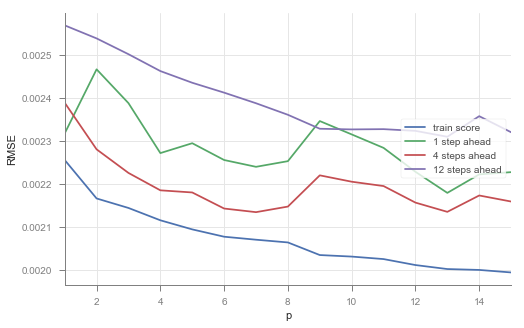

In [23]:
df = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('p')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()

# plt.savefig('destination_path.eps', format='eps', dpi=200)

## MA

In [20]:
from ARMA import ARMA as ARMA
from var_model import VAR as VAR

# test
cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


lags = 1

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
    X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

def tune(q):
    model = ARMA(0, q)

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic-ar')
    print(q)
    return q, ret[1][3].iloc[-1, 0], ret[1][0], ret[4][0], ret[12][0]

res = [tune(p) for p in range(1, 11)]

step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
1
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
2
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
3
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
4
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
5
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
6
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
7
step: 

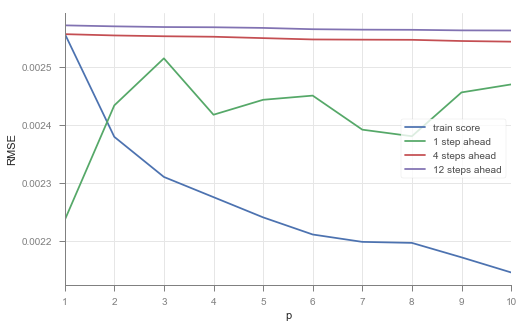

In [21]:
df = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('p')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()

# plt.savefig('destination_path.eps', format='eps', dpi=200)

## MSAR

In [25]:
from MSReg import MSReg

cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]



m = Model(model, transfs, gen_x, gen_y, RMSE)


def tune(l):
    lags = l

    def gen_x(X, start):
        X = VAR.gen_X(X, lags, start)
    #     X = X[:, 1:] # remove constant
        return X

    def gen_y(y, start):
        y = VAR.gen_y(y, lags, start)
        return y

    model = MSReg(2)

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic-ar')
    print(l)
    return l, ret[1][3].iloc[-1, 0], ret[1][0], ret[4][0], ret[12][0]

res = [tune(l) for l in range(1, 8)]

step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
1
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
2
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
3


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:391: RuntimeWarning: invalid value encountered in true_divide
  predicted_joint_probabilities[..., t+1])


step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
4
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
5
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
6
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
7


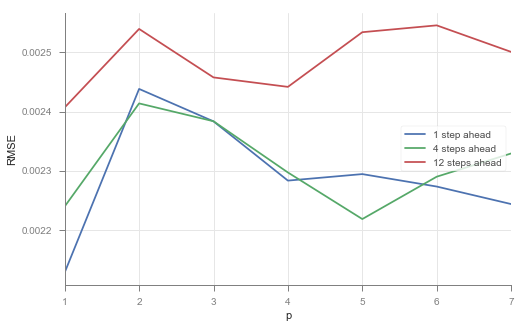

In [27]:
df = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')


legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('p')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()

# plt.savefig('destination_path.eps', format='eps', dpi=200)

## split AR

In [34]:
from splitVAR import splitVAR as splitVAR

cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]



m = Model(model, transfs, gen_x, gen_y, RMSE)


def tune(s):
    lags = 4

    def gen_x(X, start):
        X = VAR.gen_X(X, lags, start)
    #     X = X[:, 1:] # remove constant
        return X

    def gen_y(y, start):
        y = VAR.gen_y(y, lags, start)
        return y

    model = splitVAR(s, proba = True, WLS = True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols, clustering_type = 'GMM')

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
    print(s)
    return s, ret[1][3].iloc[-1, 0], ret[1][0], ret[4][0], ret[12][0]

res2 = [tune(s) for s in range(2, 6)]

step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
2
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
3
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
4
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
5


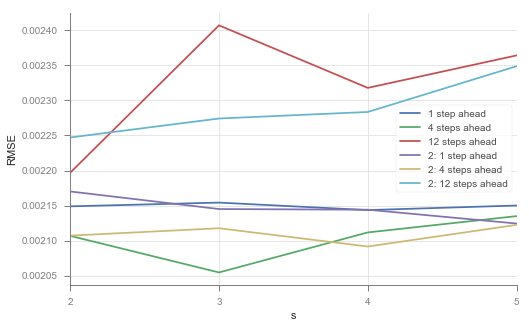

In [35]:
df = pd.DataFrame(res)
df2 = pd.DataFrame(res2)

fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')
ax.plot(df2[0], df2[2], label='2: 1 step ahead')
ax.plot(df2[0], df2[3], label='2: 4 steps ahead')
ax.plot(df2[0], df2[4], label='2: 12 steps ahead')

legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('s')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()

# plt.savefig('destination_path.eps', format='eps', dpi=200)

In [38]:
from splitVAR import splitVAR as splitVAR

from FAVAR import FAVAR

favar = FAVAR(factors_q)

cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)


m = Model(model, transfs, gen_x, gen_y, RMSE)


def tune(s):
    lags = 4

    def gen_x(X, start):
        X = VAR.gen_X(X, lags, start)
    #     X = X[:, 1:] # remove constant
        return X

    def gen_y(y, start):
        y = VAR.gen_y(y, lags, start)
        return y

    model = splitVAR(s, proba = True, WLS = True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols, clustering_type = 'kmeans')

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
    print(s)
    return s, ret[1][3].iloc[-1, 0], ret[1][0], ret[4][0], ret[12][0]

res = [tune(s) for s in range(2, 6)]

def tune(s):
    lags = 4

    def gen_x(X, start):
        X = VAR.gen_X(X, lags, start)
    #     X = X[:, 1:] # remove constant
        return X

    def gen_y(y, start):
        y = VAR.gen_y(y, lags, start)
        return y

    model = splitVAR(s, proba = True, WLS = True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols, clustering_type = 'GMM')

    m = Model(model, transfs, gen_x, gen_y, RMSE)
    window = [1, 4, 12]
    ret = m.expanding_window(X_train, y_train, TRAIN_OFFSET, window, 'dynamic')
    print(s)
    return s, ret[1][3].iloc[-1, 0], ret[1][0], ret[4][0], ret[12][0]

res2 = [tune(s) for s in range(2, 6)]

step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
2
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
3
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
4
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
5
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
2
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
3
step: 480
step: 485
step: 490
step: 495
step: 500
step: 505
step: 510
step: 515
step: 520
step: 525
step: 530
step: 535
step: 540
step: 545
4
step: 

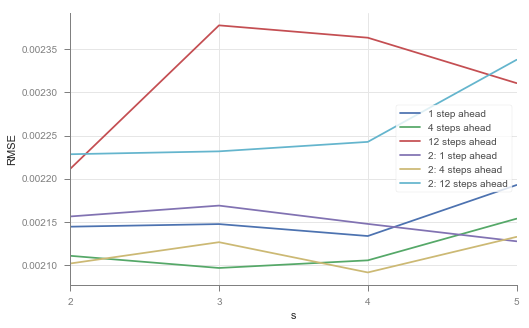

In [39]:
df = pd.DataFrame(res)
df2 = pd.DataFrame(res2)

fig, ax = plt.subplots(figsize=(8,5))

# ax.plot(df[0], df[1], label='train score')
ax.plot(df[0], df[2], label='1 step ahead')
ax.plot(df[0], df[3], label='4 steps ahead')
ax.plot(df[0], df[4], label='12 steps ahead')
ax.plot(df2[0], df2[2], label='2: 1 step ahead')
ax.plot(df2[0], df2[3], label='2: 4 steps ahead')
ax.plot(df2[0], df2[4], label='2: 12 steps ahead')

legend = ax.legend(loc='center right', frameon=True)

plt.xlabel('s')
plt.ylabel('RMSE')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(min(df[0]), max(df[0]))
    
sns.despine()

# plt.savefig('destination_path.eps', format='eps', dpi=200)